# IBM Applied Data Science Capstone Course by Coursera

### Week 5 Final Report

#### Tehran Venues Data Analysis

*Author : Sahand Niasti* 


*September, 2019*

## 1.Introduction / Business Problem

Tehran is one of the largest metropolises in the world where over 8.7 million people live in city and around 15 million people in the larger metropolitan area of Greater Tehran.  This city is the most populous city in Iran and Western Asia [1], and has the second-largest metropolitan area in the Middle East. So, it would not be shocking if you know that this city has a population density of 16,279 people per square kilometer [2]. As a resident of this city, I decided to use Tehran in my project. The city is divided into 22 districts in total. All these information tells us that this city has quite an intertwined and mixed structure.

Let say if you are a business manager who have never lived in Tehran and sees this populated city as a great opportunity to earn money. That person tends to invest in a form of café or restaurant, and our aim is to decide where or which neighborhoods should be selected to open such facility. In order to answer this question, you have to build a model get some recommendations where to start your business.

The objective of this capstone project is to analyze and select the best locations in the city of Tehran, Iran to open a café or restaurant. Using data science methodology and machine
learning techniques like clustering, and taking into account the fact that our business owner prefer to choose a district according to the social places density, leads us to the aim to provide solutions to  this business question: In the city of Tehran , if a property developer is looking to open a new café or restaurant, where would you recommend that they open it?


## 2.Data Preparation

On this section, we will consolidate the data from different data sources into a new dataset that we will use for the clustering process.

### 2.1 Import Libraries

We will first import all libraries to be used on this section, and then proceed with the data wrangling.

In [1]:
import numpy as np
import pandas as pd
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)
import json # library to handle JSON files
!pip install geocoder
!pip install geopy
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
import geocoder # to get coordinates
!pip install bs4
import requests # library to handle requests
from bs4 import BeautifulSoup # library to parse HTML and XML documents
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe
# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
# import k-means from clustering stage
from sklearn.cluster import KMeans
import folium # map rendering library
import seaborn as sns
!pip install yellowbrick
from yellowbrick.cluster import KElbowVisualizer
print("Libraries imported.")

     |████████████████████████████████| 102kB 13.0MB/s ta 0:00:01
     |████████████████████████████████| 829kB 26.8MB/s eta 0:00:01
     |████████████████████████████████| 81kB 14.0MB/s eta 0:00:01
  Stored in directory: /home/jupyterlab/.cache/pip/wheels/0c/61/d2/d6b7317325828fbb39ee6ad559dbe4664d0896da4721bf379e
Successfully built future
     |████████████████████████████████| 102kB 16.6MB/s ta 0:00:01
  Stored in directory: /home/jupyterlab/.cache/pip/wheels/99/45/d1/14954797e2a976083182c2e7da9b4e924509e59b6e5c661061
Successfully built geographiclib
     |████████████████████████████████| 102kB 17.7MB/s ta 0:00:01
  Stored in directory: /home/jupyterlab/.cache/pip/wheels/a0/b0/b2/4f80b9456b87abedbc0bf2d52235414c3467d8889be38dd472
Successfully built bs4
     |████████████████████████████████| 378kB 22.7MB/s eta 0:00:01
Libraries imported.


### 2.2 Tehran Districts data source

Fortunately, we manage to find a csv file in github related to different Boroughs located in the city of tehran. This data has been download and will be read for further analysis.

In [2]:
tehran_districts = pd.read_csv('Tehran Boroughs.csv')
tehran_districts.head()

,Name,Area,Population,Population Density
0,District 1,64.0 km²,379962,"5,936.9/km²"
1,District 2,64.0 km²,650000,"10,156.3/km²"
2,District 3,31.2 km²,293181,"9,396.8/km²"
3,District 4,61.4 km²,864946,"14,087.1/km²"
4,District 5,52.9 km²,800000,"15,122.9/km²"


In order to reuse population density in the next phases, we need to clean the column so that only numeric variables can be seen. as well as this, we will definitely rename the column title to ensure that other people will realize the ratio of this column.

In [3]:
tehran_districts['Population Density'] = tehran_districts['Population Density'].str.replace(r'\D', '').astype(int)
tehran_districts.rename(columns={'Population Density' : 'Population Density(p/km²)'}, inplace = True)

tehran_districts.head()

,Name,Area,Population,Population Density(p/km²)
0,District 1,64.0 km²,379962,59369
1,District 2,64.0 km²,650000,101563
2,District 3,31.2 km²,293181,93968
3,District 4,61.4 km²,864946,140871
4,District 5,52.9 km²,800000,151229


### 2.3 Get the geographical coordinates

In [4]:
latitude_list = []
longitude_list = []
for i in tehran_districts['Name']:    
    address = '{} , Tehran, Iran'.format(i)

    geolocator = Nominatim(user_agent="TE_explorer")
    location = geolocator.geocode(address)
    latitude = location.latitude
    latitude_list.append(latitude)
    longitude = location.longitude
    longitude_list.append(longitude)
    
print(latitude_list)
print(longitude_list)

[35.8076264, 35.7516396, 35.6877195, 35.7608893, 35.7595039, 35.7257318, 35.7248869, 35.7265679, 35.6947185, 35.6867716, 35.682822, 35.6831464, 35.7073343, 35.678057, 35.6392778, 35.6408871, 35.6595788, 35.6612525, 35.6340013, 35.6034208, 35.7193151, 35.7521532]
[51.4334159, 51.3591108076056, 51.4396385, 51.5244599, 51.3018179, 51.4011221, 51.4449548, 51.4852361, 51.3163643, 51.3663177, 51.3941791, 51.4253263, 51.4829187, 51.4813738, 51.4704848, 51.4095764, 51.3615112, 51.2969665, 51.3680909, 51.4361839, 51.1919684, 51.2281088]


In [5]:
tehran_districts['Latitude'] = latitude_list
tehran_districts['Longitude'] = longitude_list

In [6]:
tehran_districts.shape
tehran_districts.loc[2,['Latitude','Longitude']] = [35.7670237,51.396188]
tehran_districts

,Name,Area,Population,Population Density(p/km²),Latitude,Longitude
0,District 1,64.0 km²,379962,59369,35.807626,51.433416
1,District 2,64.0 km²,650000,101563,35.751640,51.359111
2,District 3,31.2 km²,293181,93968,35.767024,51.396188
3,District 4,61.4 km²,864946,140871,35.760889,51.524460
4,District 5,52.9 km²,800000,151229,35.759504,51.301818
5,District 6,21.4 km²,217127,101461,35.725732,51.401122
6,District 7,15.4 km²,309745,201133,35.724887,51.444955
7,District 8,13.4 km²,378725,282631,35.726568,51.485236
8,District 9,19.6 km²,170000,86735,35.694719,51.316364
9,District 10,8.2 km²,320000,390244,35.686772,51.366318


### 2.4 Create a map of Tehran with Boroughs superimposed on top


In [7]:
# get the coordinates of Tehran
address = 'Tehran, Iran'

geolocator = Nominatim(user_agent="my-application")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Tehran are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Tehran are 35.7006177, 51.4013785.


In [8]:
# create map of Tehran using latitude and longitude values
map_Tehran = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for lat, lng, boroughs in zip(tehran_districts['Latitude'], tehran_districts['Longitude'], tehran_districts['Name']):
    label = '{}'.format(boroughs)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.9).add_to(map_Tehran)  
    
map_Tehran

In [19]:
# save the DataFrame as CSV file
tehran_districts.to_csv("tehran_districts.csv", index=False)

In [20]:
# save the map as HTML file
map_Tehran.save('map_teh.html')

## 3. Methodology


In this phase we firstly aim to use the Foursquare Api to rxract information about venues located in Tehran, and then categorised them based on Tehran's districts

### 3.1 Use the Foursquare API to explore the Boroughs

In [9]:
# define Foursquare Credentials and Version
CLIENT_ID = 'CJIGG0BEJH5FLEAHCR3ALREF2QZMOTVOBGQOKWQ0MV4LXYQ2' # your Foursquare ID
CLIENT_SECRET = 'DE550DPJTNXQCHSRW4OFARSZI5CQGXUS1N3RPEWG5CGE2WSO' # your Foursquare Secret
VERSION = '20191808' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: CJIGG0BEJH5FLEAHCR3ALREF2QZMOTVOBGQOKWQ0MV4LXYQ2
CLIENT_SECRET:DE550DPJTNXQCHSRW4OFARSZI5CQGXUS1N3RPEWG5CGE2WSO


Now, let's get the top 100 venues that are within a radius of 3000 meters

In [10]:
radius = 3000
LIMIT = 100

venues = []

for lat, long, neighborhood, density  in zip(tehran_districts['Latitude'], tehran_districts['Longitude'], tehran_districts['Name'], tehran_districts['Population Density(p/km²)']):
    
    # create the API request URL
    url = "https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}".format(
        CLIENT_ID,
        CLIENT_SECRET,
        VERSION,
        lat,
        long,
        radius, 
        LIMIT)
    
    # make the GET request
    results = requests.get(url).json()["response"]['groups'][0]['items']
    
    # return only relevant information for each nearby venue
    for venue in results:
        venues.append((
            neighborhood,
            density,
            lat, 
            long, 
            venue['venue']['name'], 
            venue['venue']['location']['lat'], 
            venue['venue']['location']['lng'],  
            venue['venue']['categories'][0]['name']))

In [11]:
# convert the venues list into a new DataFrame
venues_df = pd.DataFrame(venues)

# define the column names
venues_df.columns = ['Boroughs','Population Density(p/km²)', 'Latitude', 'Longitude', 'VenueName', 'VenueLatitude', 'VenueLongitude', 'VenueCategory']

print(venues_df.shape)
venues_df.head()

(1465, 8)


,Boroughs,Population Density(p/km²),Latitude,Longitude,VenueName,VenueLatitude,VenueLongitude,VenueCategory
0,District 1,59369,35.807626,51.433416,Sahar Bakery | نان سحر (نان سحر),35.805743,51.431786,Bakery
1,District 1,59369,35.807626,51.433416,Inverse School,35.805574,51.435028,School
2,District 1,59369,35.807626,51.433416,Astara Movie Theater | سینما آستارا (سینما آست...,35.806421,51.431039,Multiplex
3,District 1,59369,35.807626,51.433416,شیرینی تارت | Taart Confectionary (شیرینی تارت),35.808343,51.436258,Pastry Shop
4,District 1,59369,35.807626,51.433416,Tajrish Bazaar | بازار تجریش (بازار تجریش),35.805868,51.429956,Market


Let's check how many venues were returned for each Boroughs

In [12]:
#venues for each borough
categorised_boroughs = venues_df.groupby(["Boroughs"]).count()
categorised_boroughs

,Population Density(p/km²),Latitude,Longitude,VenueName,VenueLatitude,VenueLongitude,VenueCategory
Boroughs,,,,,,,
District 1,100,100,100,100,100,100,100
District 10,81,81,81,81,81,81,81
District 11,100,100,100,100,100,100,100
District 12,100,100,100,100,100,100,100
District 13,87,87,87,87,87,87,87
District 14,49,49,49,49,49,49,49
District 15,32,32,32,32,32,32,32
District 16,33,33,33,33,33,33,33
District 17,29,29,29,29,29,29,29


In [13]:
categorised_boroughs.reset_index(inplace=True)
categorised_boroughs.head(3)

,Boroughs,Population Density(p/km²),Latitude,Longitude,VenueName,VenueLatitude,VenueLongitude,VenueCategory
0,District 1,100,100,100,100,100,100,100
1,District 10,81,81,81,81,81,81,81
2,District 11,100,100,100,100,100,100,100


In [14]:

# Count the number of locations per Venue Category in Tehran
venues_df.groupby(["VenueCategory"]).count()['Boroughs'].sort_values(ascending = False).head(10)

VenueCategory
Café                    123
Persian Restaurant       82
Park                     73
Plaza                    69
Pastry Shop              65
Ice Cream Shop           56
Fast Food Restaurant     51
Bookstore                42
Shopping Mall            37
Sandwich Place           37
Name: Boroughs, dtype: int64

Let's find out how many unique categories can be curated from all the returned venues


In [15]:
print('There are {} uniques categories.'.format(len(venues_df['VenueCategory'].unique())))


There are 187 uniques categories.


In [16]:

# print out the list of categories
venues_df['VenueCategory'].unique()

array(['Bakery', 'School', 'Multiplex', 'Pastry Shop', 'Market',
       'Snack Place', 'Plaza', 'Persian Restaurant', 'Coffee Shop',
       'BBQ Joint', 'Park', 'Czech Restaurant', 'Climbing Gym',
       'Shoe Store', 'Ash and Haleem Place', 'Museum',
       'Accessories Store', 'Juice Bar', 'Cultural Center',
       'Shopping Mall', 'Art Museum', 'Historic Site',
       'Paper / Office Supplies Store', 'Café', 'Ice Cream Shop',
       'History Museum', 'Fruit & Vegetable Store', 'Mountain', 'Garden',
       'Gym', 'Bookstore', 'Department Store', 'Art Gallery',
       'Pizza Place', 'Volleyball Court', 'Gourmet Shop',
       'Salon / Barbershop', 'Hobby Shop', 'Gym / Fitness Center',
       'Amphitheater', 'Arts & Crafts Store', 'Scenic Lookout',
       'Jewelry Store', 'Sports Club', 'Flower Shop', 'Supermarket',
       'Drugstore', 'Doner Restaurant', 'Restaurant', 'Yoga Studio',
       'Jegaraki', 'Health & Beauty Service', 'Massage Studio',
       'Grocery Store', 'Burger Joint', 

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


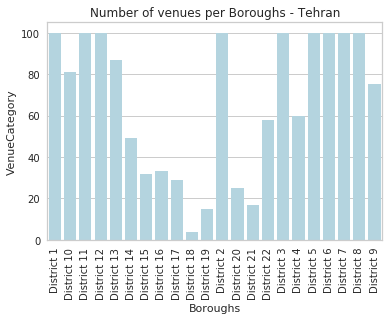

In [17]:

#Plot number of venues registered per borough for Tehran
ax = sns.barplot(x='Boroughs',y='VenueCategory',data=categorised_boroughs, color='lightblue')
ax.set_title('Number of venues per Boroughs - Tehran')
ax.set_xticklabels(labels=categorised_boroughs['Boroughs'],rotation=90);

## 4. Analyze Each Neighborhood

In [18]:
# one hot encoding
Tehran_onehot = pd.get_dummies(venues_df[['VenueCategory']], prefix="", prefix_sep="")

# Boroughs column back to dataframe
Tehran_onehot['Boroughs'] = venues_df['Boroughs'] 


# move Boroughs column to the first column
fixed_columns = [Tehran_onehot.columns[-1]] + list(Tehran_onehot.columns[:-1])
Tehran_onehot = Tehran_onehot[fixed_columns]

print(Tehran_onehot.shape)
Tehran_onehot.head()

(1465, 188)


,Boroughs,Accessories Store,Airport,Airport Lounge,Airport Service,Amphitheater,Antique Shop,Art Gallery,Art Museum,Arts & Crafts Store,Ash and Haleem Place,Astrologer,Athletics & Sports,Auditorium,Auto Garage,Auto Workshop,Automotive Shop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Big Box Store,Bike Trail,Bistro,Bookstore,Botanical Garden,Boutique,Bowling Alley,Breakfast Spot,Buffet,Burger Joint,Bus Station,Café,Camera Store,Candy Store,Carpet Store,Cheese Shop,Chocolate Shop,Climbing Gym,Clothing Store,Coffee Shop,Comfort Food Restaurant,Concert Hall,Construction & Landscaping,Cosmetics Shop,Costume Shop,Creperie,Cultural Center,Czech Restaurant,Dairy Store,Department Store,Dessert Shop,Diner,Dizi Place,Doner Restaurant,Drugstore,Electronics Store,Event Space,Falafel Restaurant,Fast Food Restaurant,Fish & Chips Shop,Flea Market,Flower Shop,Food & Drink Shop,Food Court,Forest,Fried Chicken Joint,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gilaki Restaurant,Go Kart Track,Gourmet Shop,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Health & Beauty Service,Historic Site,History Museum,Hobby Shop,Hookah Bar,Hospital,Hostel,Hot Dog Joint,Hotel,IT Services,Ice Cream Shop,Indian Restaurant,Indoor Play Area,Insurance Office,Intersection,Italian Restaurant,Japanese Restaurant,Jegaraki,Jewelry Store,Juice Bar,Kebab Restaurant,Kitchen Supply Store,Leather Goods Store,Lebanese Restaurant,Lounge,Market,Massage Studio,Mattress Store,Medical Center,Mediterranean Restaurant,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Mobile Phone Shop,Monument / Landmark,Moroccan Restaurant,Mosque,Motel,Motorcycle Shop,Mountain,Movie Theater,Multiplex,Museum,Music Store,Music Venue,National Park,Neighborhood,Office,Optical Shop,Palace,Paper / Office Supplies Store,Park,Parking,Pastry Shop,Pedestrian Plaza,Perfume Shop,Persian Restaurant,Pet Store,Pharmacy,Pizza Place,Playground,Plaza,Pool,Print Shop,Public Art,Recording Studio,Recreation Center,Restaurant,Road,Salon / Barbershop,Sandwich Place,Scenic Lookout,School,Seafood Restaurant,Shoe Store,Shopping Mall,Snack Place,Soccer Field,Soccer Stadium,Social Club,Soup Place,Spa,Sporting Goods Shop,Sports Club,Squash Court,Stables,Stadium,Stationery Store,Steakhouse,Street Art,Street Food Gathering,Supermarket,Tabbakhi,Taxi Stand,Tea Room,Tennis Court,Tennis Stadium,Thai Restaurant,Theater,Theme Park Ride / Attraction,Toy / Game Store,Trail,Train Station,Tunnel,Turkish Restaurant,Volleyball Court,Wings Joint,Yoga Studio,Zoo
0,District 1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,District 1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,District 1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,District 1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0

 Next, let's group rows by Boroughs and by taking the mean of the frequency of occurrence of each category



In [19]:

Tehran_grouped = Tehran_onehot.groupby(["Boroughs"]).mean().reset_index()
print(Tehran_grouped.shape)
Tehran_grouped

(22, 188)


,Boroughs,Accessories Store,Airport,Airport Lounge,Airport Service,Amphitheater,Antique Shop,Art Gallery,Art Museum,Arts & Crafts Store,Ash and Haleem Place,Astrologer,Athletics & Sports,Auditorium,Auto Garage,Auto Workshop,Automotive Shop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Big Box Store,Bike Trail,Bistro,Bookstore,Botanical Garden,Boutique,Bowling Alley,Breakfast Spot,Buffet,Burger Joint,Bus Station,Café,Camera Store,Candy Store,Carpet Store,Cheese Shop,Chocolate Shop,Climbing Gym,Clothing Store,Coffee Shop,Comfort Food Restaurant,Concert Hall,Construction & Landscaping,Cosmetics Shop,Costume Shop,Creperie,Cultural Center,Czech Restaurant,Dairy Store,Department Store,Dessert Shop,Diner,Dizi Place,Doner Restaurant,Drugstore,Electronics Store,Event Space,Falafel Restaurant,Fast Food Restaurant,Fish & Chips Shop,Flea Market,Flower Shop,Food & Drink Shop,Food Court,Forest,Fried Chicken Joint,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gilaki Restaurant,Go Kart Track,Gourmet Shop,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Health & Beauty Service,Historic Site,History Museum,Hobby Shop,Hookah Bar,Hospital,Hostel,Hot Dog Joint,Hotel,IT Services,Ice Cream Shop,Indian Restaurant,Indoor Play Area,Insurance Office,Intersection,Italian Restaurant,Japanese Restaurant,Jegaraki,Jewelry Store,Juice Bar,Kebab Restaurant,Kitchen Supply Store,Leather Goods Store,Lebanese Restaurant,Lounge,Market,Massage Studio,Mattress Store,Medical Center,Mediterranean Restaurant,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Mobile Phone Shop,Monument / Landmark,Moroccan Restaurant,Mosque,Motel,Motorcycle Shop,Mountain,Movie Theater,Multiplex,Museum,Music Store,Music Venue,National Park,Neighborhood,Office,Optical Shop,Palace,Paper / Office Supplies Store,Park,Parking,Pastry Shop,Pedestrian Plaza,Perfume Shop,Persian Restaurant,Pet Store,Pharmacy,Pizza Place,Playground,Plaza,Pool,Print Shop,Public Art,Recording Studio,Recreation Center,Restaurant,Road,Salon / Barbershop,Sandwich Place,Scenic Lookout,School,Seafood Restaurant,Shoe Store,Shopping Mall,Snack Place,Soccer Field,Soccer Stadium,Social Club,Soup Place,Spa,Sporting Goods Shop,Sports Club,Squash Court,Stables,Stadium,Stationery Store,Steakhouse,Street Art,Street Food Gathering,Supermarket,Tabbakhi,Taxi Stand,Tea Room,Tennis Court,Tennis Stadium,Thai Restaurant,Theater,Theme Park Ride / Attraction,Toy / Game Store,Trail,Train Station,Tunnel,Turkish Restaurant,Volleyball Court,Wings Joint,Yoga Studio,Zoo
0,District 1,0.01,0.000000,0.000000,0.000000,0.01,0.00,0.01,0.04,0.010000,0.020000,0.00,0.000000,0.00,0.000000,0.000000,0.000000,0.020000,0.00,0.00,0.020000,0.00,0.000000,0.000000,0.020000,0.000000,0.000000,0.00,0.000000,0.00,0.000000,0.000000,0.040000,0.00,0.00,0.000000,0.00,0.00,0.01,0.000000,0.010000,0.00,0.00,0.000000,0.000000,0.000000,0.00,0.01,0.01,0.00,0.010000,0.000000,0.000000,0.000000,0.010000,0.010000,0.00000,0.00,0.000000,0.000000,0.00,0.00,0.010000,0.00,0.000000,0.000000,0.000000,0.020000,0.000000,0.00,0.010000,0.000000,0.00,0.00,0.01,0.00,0.030000,0.020000,0.000000,0.01,0.010000,0.060000,0.01,0.000000,0.000000,0.00,0.00,0.000000,0.00,0.030000,0.00,0.00,0.000000,0.000000,0.000000,0.00,0.010000,0.02,0.020000,0.000000,0.000000,0.00,0.000000,0.00000,0.040000,0.00,0.00,0.00,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.00,0.000000,0.000000,0.02,0.000000,0.010000,0.020000,0.00,0.00,0.000000,0.00,0.00,0.00,0.000000,0.01,0.020000,0.00,0.070000,0.000000,0.00,0.080000,0.000000,0.000000,0.020000,0.000000,0.020000,0.000000,0.00,0.000000,0.000000,0.000000,0.010000,0.000000,0.01,0.000000,0.02,0.01,0.000000,0.02,0.020000,0.01,0.000000,0.00,0.00000,0.00,0.00,0.000000,0.010000,0.00,0.000000,0.000000,0.000000,0.00,0.000000,0.00,0.020000,0.000000,0.000000,0.000000,0.000000,0.00,0.00,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.01,0.00,0.010000,0.000000
1,District 10,0.00,0.000000,0.000000,0.012346,0.00,0.00,0.00,0.00,0.012346

In [20]:
num_top_venues = 10

for hood in Tehran_grouped['Boroughs']:
    print("----"+hood+"----")
    temp = Tehran_grouped[Tehran_grouped['Boroughs'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----District 1----
                  venue  freq
0    Persian Restaurant  0.08
1           Pastry Shop  0.07
2        History Museum  0.06
3                Market  0.04
4                  Café  0.04
5            Art Museum  0.04
6        Ice Cream Shop  0.03
7                   Gym  0.03
8  Gym / Fitness Center  0.02
9             Bookstore  0.02


----District 10----
              venue  freq
0    Ice Cream Shop  0.09
1             Plaza  0.06
2              Café  0.06
3         Bookstore  0.05
4       Pastry Shop  0.04
5  Kebab Restaurant  0.04
6     Shopping Mall  0.04
7        Dizi Place  0.04
8    Sandwich Place  0.04
9       Coffee Shop  0.04


----District 11----
                venue  freq
0                Café  0.10
1           Bookstore  0.08
2             Theater  0.08
3      History Museum  0.07
4  Persian Restaurant  0.06
5          Hookah Bar  0.04
6         Coffee Shop  0.04
7      Sandwich Place  0.03
8       Historic Site  0.03
9         Snack Place  0.02


----Distric

#### 4.1 a *pandas* dataframe creation

First, let's write a function to sort the venues in descending order.

In [21]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

Now let's create the new dataframe and display the top 10 venues for each neighborhood

In [22]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Boroughs']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
Boroughs_venues_sorted = pd.DataFrame(columns=columns)
Boroughs_venues_sorted['Boroughs'] = Tehran_grouped['Boroughs']

for ind in np.arange(Tehran_grouped.shape[0]):
    Boroughs_venues_sorted.iloc[ind, 1:] = return_most_common_venues(Tehran_grouped.iloc[ind, :], num_top_venues)

Boroughs_venues_sorted.head()

,Boroughs,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,District 1,Persian Restaurant,Pastry Shop,History Museum,Market,Art Museum,Café,Gym,Ice Cream Shop,Shoe Store,Shopping Mall
1,District 10,Ice Cream Shop,Plaza,Café,Bookstore,Pastry Shop,Dizi Place,Kebab Restaurant,Coffee Shop,Shopping Mall,Sandwich Place
2,District 11,Café,Theater,Bookstore,History Museum,Persian Restaurant,Coffee Shop,Hookah Bar,Sandwich Place,Historic Site,Breakfast Spot
3,District 12,History Museum,Persian Restaurant,Historic Site,Café,Theater,Market,Sandwich Place,Pastry Shop,Pedestrian Plaza,Ice Cream Shop
4,District 13,Plaza,Café,Park,Persian Restaurant,Fast Food Restaurant,Ice Cream Shop,Pastry Shop,Pizza Place,Shopping Mall,Clothing Store


## 5. Cluster Boroughs


We have some common venue categories in boroughs. In this reason I used unsupervised learning K-means algorithm to cluster the boroughs. K-Means algorithm is one of the most common cluster method of unsupervised learning. First, I will run K-Means to cluster the boroughs into 8 clusters because when I analyze the K-Means with elbow method it ensured me the 8 degree for optimum k of the K-Means.





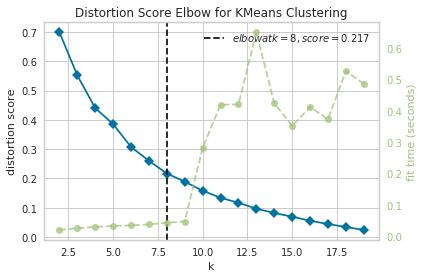

In [24]:
Tehran_grouped_clustering = Tehran_grouped.drop('Boroughs', axis = 1)
# Instantiate the clustering model and visualizer
model = KMeans()
visualizer = KElbowVisualizer(model, k=(2,20),)

visualizer.fit(Tehran_grouped_clustering)        # Fit the data to the visualizer
visualizer.poof()        # Draw/show/poof the data

Run *k*-means to cluster the neighborhood into 9 clusters.

In [25]:
# set number of clusters
kclusters = 8

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(Tehran_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_

array([5, 5, 5, 5, 7, 7, 1, 6, 4, 3, 4, 2, 1, 0, 2, 2, 2, 2, 2, 5, 7, 2],
      dtype=int32)

Let's create a new dataframe that includes the cluster as well as the top 10 venues for each Borough.

In [26]:
# add clustering labels
Boroughs_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)
Boroughs_venues_sorted


,Cluster Labels,Boroughs,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,5,District 1,Persian Restaurant,Pastry Shop,History Museum,Market,Art Museum,Café,Gym,Ice Cream Shop,Shoe Store,Shopping Mall
1,5,District 10,Ice Cream Shop,Plaza,Café,Bookstore,Pastry Shop,Dizi Place,Kebab Restaurant,Coffee Shop,Shopping Mall,Sandwich Place
2,5,District 11,Café,Theater,Bookstore,History Museum,Persian Restaurant,Coffee Shop,Hookah Bar,Sandwich Place,Historic Site,Breakfast Spot
3,5,District 12,History Museum,Persian Restaurant,Historic Site,Café,Theater,Market,Sandwich Place,Pastry Shop,Pedestrian Plaza,Ice Cream Shop
4,7,District 13,Plaza,Café,Park,Persian Restaurant,Fast Food Restaurant,Ice Cream Shop,Pastry Shop,Pizza Place,Shopping Mall,Clothing Store
5,7,District 14,Plaza,Park,Fast Food Restaurant,Pizza Place,Pastry Shop,Ice Cream Shop,Persian Restaurant,Fried Chicken Joint,Bus Station,Shopping Mall
6,1,District 15,Middle Eastern Restaurant,Pastry Shop,Park,Plaza,Persian Restaurant,Shopping Mall,Juice Bar,Bakery,Lounge,Bus Station
7,6,District 16,BBQ Joint,Plaza,Persian Restaurant,Park,Train Station,Ice Cream Shop,Furniture / Home Store,Kitchen Supply Store,Clothing Store,Bookstore
8,4,District 17,Furniture / Home Store,Park,Plaza,Persian Restaurant,Multiplex,Shopping Mall,Movie Theater,Recreation Center,Recording Studio,Metro Station
9,3,District 18,Plaza,Shopping Mall,Auto Garage,Cheese Shop,Fast Food Restaurant,Fried Chicken Joint,Forest,Food Court,Food & Drink Shop,Flower Shop


In [27]:
Tehran_merged = tehran_districts

# merge Tehran_grouped with main data to add latitude/longitude for each neighborhood
Tehran_merged = Tehran_merged.join(Boroughs_venues_sorted.set_index('Boroughs'), on='Name')

Tehran_merged # check the last columns!

,Name,Area,Population,Population Density(p/km²),Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,District 1,64.0 km²,379962,59369,35.807626,51.433416,5,Persian Restaurant,Pastry Shop,History Museum,Market,Art Museum,Café,Gym,Ice Cream Shop,Shoe Store,Shopping Mall
1,District 2,64.0 km²,650000,101563,35.751640,51.359111,2,Café,Park,Gym / Fitness Center,Bakery,Pastry Shop,Bookstore,Italian Restaurant,Gym,Jewelry Store,Fast Food Restaurant
2,District 3,31.2 km²,293181,93968,35.767024,51.396188,2,Café,Gym / Fitness Center,Park,Bakery,Gym,Fast Food Restaurant,Coffee Shop,Italian Restaurant,Tennis Court,Bookstore
3,District 4,61.4 km²,864946,140871,35.760889,51.524460,2,Persian Restaurant,Café,Park,Ice Cream Shop,Market,Pizza Place,Italian Restaurant,Tennis Court,Restaurant,Plaza
4,District 5,52.9 km²,800000,151229,35.759504,51.301818,2,Fast Food Restaurant,Ice Cream Shop,Café,Park,Persian Restaurant,Hookah Bar,Burger Joint,Pastry Shop,Shopping Mall,Jegaraki
5,District 6,21.4 km²,217127,101461,35.725732,51.401122,2,Café,Pastry Shop,Bookstore,Sandwich Place,Art Gallery,Park,Tabbakhi,Burger Joint,Coffee Shop,Persian Restaurant
6,District 7,15.4 km²,309745,201133,35.724887,51.444955,5,Café,Sandwich Place,Persian Restaurant,Pastry Shop,Bookstore,Ice Cream Shop,Kebab Restaurant,Supermarket,Dizi Place,Coffee Shop
7,District 8,13.4 km²,378725,282631,35.726568,51.485236,7,Fast Food Restaurant,Plaza,Park,Pastry Shop,Italian Restaurant,Café,Persian Restaurant,Ice Cream Shop,Sandwich Place,Pizza Place
8,District 9,19.6 km²,170000,86735,35.694719,51.316364,2,Café,Airport Lounge,Fast Food Restaurant,Coffee Shop,Plaza,Shopping Mall,Market,Park,Department Store,Ice Cream Shop
9,District 10,8.2 km²,320000,390244,35.686772,51.366318,5,Ice Cream Shop,Plaza,Café,Bookstore,Pastry Shop,Dizi Place,Kebab Restaurant,Coffee Shop,Shopping Mall,Sandwich Place


Now the clustered borough can be visualized on the map

In [28]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(Tehran_merged['Latitude'], Tehran_merged['Longitude'], Tehran_merged['Name'], Tehran_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.95).add_to(map_clusters)
       
map_clusters

In [29]:

# save the map as HTML file
map_clusters.save('map_clusters.html')

## 6. Examine Clusters


In [30]:
Table_Clusters = Boroughs_venues_sorted.groupby('Cluster Labels').count()


In [31]:
Table_Clusters.reset_index(inplace = True)

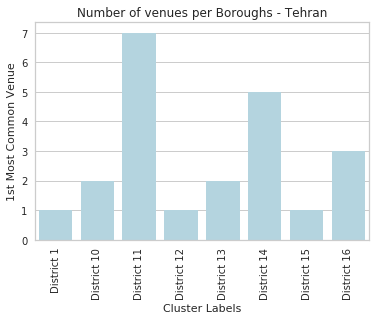

In [32]:
ax = sns.barplot(x='Cluster Labels',y='1st Most Common Venue',data=Table_Clusters, color='lightblue')
ax.set_title('Number of venues per Boroughs - Tehran')
ax.set_xticklabels(labels=categorised_boroughs['Boroughs'],rotation=90);

In [33]:
Tehran_merged.loc[Tehran_merged['Cluster Labels'] == 0]

,Name,Area,Population,Population Density(p/km²),Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
20,District 21,51.6 km²,157939,30608,35.719315,51.191968,0,Stables,Auto Workshop,Historic Site,Street Art,Museum,Auto Garage,Carpet Store,Athletics & Sports,National Park,Bike Trail


In [34]:
Tehran_merged.loc[Tehran_merged['Cluster Labels'] == 1]

,Name,Area,Population,Population Density(p/km²),Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
14,District 15,35.4 km²,694678,196237,35.639278,51.470485,1,Middle Eastern Restaurant,Pastry Shop,Park,Plaza,Persian Restaurant,Shopping Mall,Juice Bar,Bakery,Lounge,Bus Station
19,District 20,23.0 km²,378445,164541,35.603421,51.436184,1,Plaza,Middle Eastern Restaurant,Pastry Shop,Persian Restaurant,Accessories Store,Bakery,History Museum,Historic Site,Juice Bar,Market


In [35]:
Tehran_merged.loc[Tehran_merged['Cluster Labels'] == 2]

,Name,Area,Population,Population Density(p/km²),Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,District 2,64.0 km²,650000,101563,35.751640,51.359111,2,Café,Park,Gym / Fitness Center,Bakery,Pastry Shop,Bookstore,Italian Restaurant,Gym,Jewelry Store,Fast Food Restaurant
2,District 3,31.2 km²,293181,93968,35.767024,51.396188,2,Café,Gym / Fitness Center,Park,Bakery,Gym,Fast Food Restaurant,Coffee Shop,Italian Restaurant,Tennis Court,Bookstore
3,District 4,61.4 km²,864946,140871,35.760889,51.524460,2,Persian Restaurant,Café,Park,Ice Cream Shop,Market,Pizza Place,Italian Restaurant,Tennis Court,Restaurant,Plaza
4,District 5,52.9 km²,800000,151229,35.759504,51.301818,2,Fast Food Restaurant,Ice Cream Shop,Café,Park,Persian Restaurant,Hookah Bar,Burger Joint,Pastry Shop,Shopping Mall,Jegaraki
5,District 6,21.4 km²,217127,101461,35.725732,51.401122,2,Café,Pastry Shop,Bookstore,Sandwich Place,Art Gallery,Park,Tabbakhi,Burger Joint,Coffee Shop,Persian Restaurant
8,District 9,19.6 km²,170000,86735,35.694719,51.316364,2,Café,Airport Lounge,Fast Food Restaurant,Coffee Shop,Plaza,Shopping Mall,Market,Park,Department Store,Ice Cream Shop
21,District 22,54.0 km²,138970,25735,35.752153,51.228109,2,Café,Fast Food Restaurant,Persian Restaurant,Pastry Shop,Plaza,Shopping Mall,Pizza Place,Supermarket,Lebanese Restaurant,Park


In [36]:
Tehran_merged.loc[Tehran_merged['Cluster Labels'] == 3]

,Name,Area,Population,Population Density(p/km²),Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
17,District 18,37.5 km²,317110,84567,35.661253,51.296967,3,Plaza,Shopping Mall,Auto Garage,Cheese Shop,Fast Food Restaurant,Fried Chicken Joint,Forest,Food Court,Food & Drink Shop,Flower Shop


In [37]:
Tehran_merged.loc[Tehran_merged['Cluster Labels'] == 4]

,Name,Area,Population,Population Density(p/km²),Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
16,District 17,8.2 km²,256022,312222,35.659579,51.361511,4,Furniture / Home Store,Park,Plaza,Persian Restaurant,Multiplex,Shopping Mall,Movie Theater,Recreation Center,Recording Studio,Metro Station
18,District 19,20.3 km²,249786,123049,35.634001,51.368091,4,Park,Ice Cream Shop,Furniture / Home Store,Fruit & Vegetable Store,Movie Theater,Multiplex,Shopping Mall,Market,Breakfast Spot,Plaza


In [38]:
Tehran_merged.loc[Tehran_merged['Cluster Labels'] == 5]

,Name,Area,Population,Population Density(p/km²),Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,District 1,64.0 km²,379962,59369,35.807626,51.433416,5,Persian Restaurant,Pastry Shop,History Museum,Market,Art Museum,Café,Gym,Ice Cream Shop,Shoe Store,Shopping Mall
6,District 7,15.4 km²,309745,201133,35.724887,51.444955,5,Café,Sandwich Place,Persian Restaurant,Pastry Shop,Bookstore,Ice Cream Shop,Kebab Restaurant,Supermarket,Dizi Place,Coffee Shop
9,District 10,8.2 km²,320000,390244,35.686772,51.366318,5,Ice Cream Shop,Plaza,Café,Bookstore,Pastry Shop,Dizi Place,Kebab Restaurant,Coffee Shop,Shopping Mall,Sandwich Place
10,District 11,12.6 km²,280000,222222,35.682822,51.394179,5,Café,Theater,Bookstore,History Museum,Persian Restaurant,Coffee Shop,Hookah Bar,Sandwich Place,Historic Site,Breakfast Spot
11,District 12,16.9 km²,365000,215976,35.683146,51.425326,5,History Museum,Persian Restaurant,Historic Site,Café,Theater,Market,Sandwich Place,Pastry Shop,Pedestrian Plaza,Ice Cream Shop


In [39]:
Tehran_merged.loc[Tehran_merged['Cluster Labels'] == 6]

,Name,Area,Population,Population Density(p/km²),Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
15,District 16,18.1 km²,332000,183425,35.640887,51.409576,6,BBQ Joint,Plaza,Persian Restaurant,Park,Train Station,Ice Cream Shop,Furniture / Home Store,Kitchen Supply Store,Clothing Store,Bookstore


In [40]:
Tehran_merged.loc[Tehran_merged['Cluster Labels'] == 7]

,Name,Area,Population,Population Density(p/km²),Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
7,District 8,13.4 km²,378725,282631,35.726568,51.485236,7,Fast Food Restaurant,Plaza,Park,Pastry Shop,Italian Restaurant,Café,Persian Restaurant,Ice Cream Shop,Sandwich Place,Pizza Place
12,District 13,12.8 km²,275727,215412,35.707334,51.482919,7,Plaza,Café,Park,Persian Restaurant,Fast Food Restaurant,Ice Cream Shop,Pastry Shop,Pizza Place,Shopping Mall,Clothing Store
13,District 14,24.3 km²,483432,198943,35.678057,51.481374,7,Plaza,Park,Fast Food Restaurant,Pizza Place,Pastry Shop,Ice Cream Shop,Persian Restaurant,Fried Chicken Joint,Bus Station,Shopping Mall


In [41]:
Tehran_merged.loc[Tehran_merged['Cluster Labels'] == 8]

,Name,Area,Population,Population Density(p/km²),Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue


# 7.Final Map

In [42]:
Tehran_geo = r'tehran_districts.json' # geojson file

# create a plain map of Tehran
Tehran_map = folium.Map(location=[latitude, longitude], zoom_start=11,)

In [43]:
# generate choropleth map using cluster labels to categorise the boroughs in Tehran
Tehran_map.choropleth(
    geo_data=Tehran_geo,
    data=tehran_districts,
    columns=['Name', 'Population Density(p/km²)'],
    key_on='feature.properties.name',
    fill_color='YlOrRd', 
    fill_opacity=0.4, 
    line_opacity=0.4,
    legend_name='Population Density (per Km²)'
)

# display map
Tehran_map

In [45]:
markers_colors = []
for lat, lon, poi, cluster in zip(Tehran_merged['Latitude'], Tehran_merged['Longitude'], Tehran_merged['Name'], Tehran_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.95).add_to(Tehran_map)
       
Tehran_map